In [1]:
# %matplotlib inline

NLP From Scratch: Classifying Names with a Character-Level RNN
==============================================================

**Author**: [Sean Robertson](https://github.com/spro),,, Note: this notebook is modified from the original one.

A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step, feeding its previous
hidden state into each next step. We take the final prediction to be the
output, i.e. which class the word belongs to.

Specifically, we\'ll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling. Examples of a trained RNN model\'s output are:

``` {.sourceCode .sh}
print(predict(Hinton))
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

print(predict(Schmidhuber))
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

Recommended Preparation
-----------------------

To fully understand this lab it is advised that you have a basic understanding of Python programming language, PyTorch, 
and Tensors. The below resources are recommended; Nevertheless, previous weeks\' labs gave you the appropriate background to directly start with this lab\'s excersices.

-   <https://pytorch.org/> For installation instructions
-   `/beginner/deep_learning_60min_blitz`{.interpreted-text role="doc"}
    to get started with PyTorch in general and learn the basics of
    Tensors
-   `/beginner/pytorch_with_examples`{.interpreted-text role="doc"} for
    a wide and deep overview
-   `/beginner/former_torchies_tutorial`{.interpreted-text role="doc"}
    if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-   [The Unreasonable Effectiveness of Recurrent Neural
    Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    shows a bunch of real life examples
-   [Understanding LSTM
    Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    is about LSTMs specifically but also informative about RNNs in
    general

Preparing the Data
------------------

Data are saved in the directory 'data/names'. It includes 18 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We\'ll end up with a dictionary of lists of names per language,
`{language: [names ...]}`. The generic variables \"category\" and
\"line\" (for language and name in our case) are used for later
extensibility.


In [2]:
# If you are using your local machine, you should not comment 'f_path = 'data/names/*.txt'' and the rest of this block should be kept commented
f_path = 'data/names/*.txt'
# if you are using colab, please uncomment all the below lines then follow below instructions:
# # - save the folder 'data' into you google drive. You can find this folder in week5/labs/day5/data
# # - run the below two lines to initiate the connection to your google drive account
# from google.colab import drive
# drive.mount('/content/drive')

# # - Locate where you stored the folder and insert its path in the temp_path variable
# temp_path = '/content/drive/MyDrive/my_AI_course' #this is an example
# f_path = temp_path+'/data/names/*.txt'

# # - Providing the correct path will let you run the next block without an error.

In [3]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

test_f_list = findFiles(f_path)
assert not (test_f_list == []), 'The folder couldn\'t be loaded correctly!'
print(test_f_list)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(f"Plain ASCII of 'Ślusàrski' is {unicodeToAscii('Ślusàrski')}")

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(f_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Plain ASCII of 'Ślusàrski' is Slusarski


Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [4]:
print(f'all_letters list is {all_letters} with a length of {n_letters}')
print(f'The considered categories are {all_categories}')
print(f'A sample of a category is {category_lines['Italian'][:5]}')

all_letters list is abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;' with a length of 57
The considered categories are ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
A sample of a category is ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Task-1: Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    #To Do start
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    #To Do end
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    #To Do start
    tensor = torch.zeros(len(line), 1, n_letters) ### Inatialize the 1hot vector with zeros
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1 ### Fill the correct letter index with 1
    #To Do end
    return tensor

print(letterToTensor('J').size(), letterToTensor('J'))

print(lineToTensor('Jones').size())

torch.Size([1, 57]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Task-1: Simple Check
==========================
The below code should be ran without any error

In [6]:
test_vec = torch.zeros(1,57)
test_vec[0][35] = 1.0
test_line = torch.zeros(5, 1, 57)
assert letterToTensor('J').size() == test_vec.size()
assert torch.all(letterToTensor('J') == test_vec)
assert lineToTensor('Jones').size() == test_line.size()
print('Passed!')


Passed!


Task-2: Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very \"pure\" way,
as regular feed-forward layers.

We want to build a \"vanilla RNN\" with just 3 linear layers
that operate on an input and hidden state, with a `LogSoftmax` layer
after the output. Refer to the below diagram to build the network.

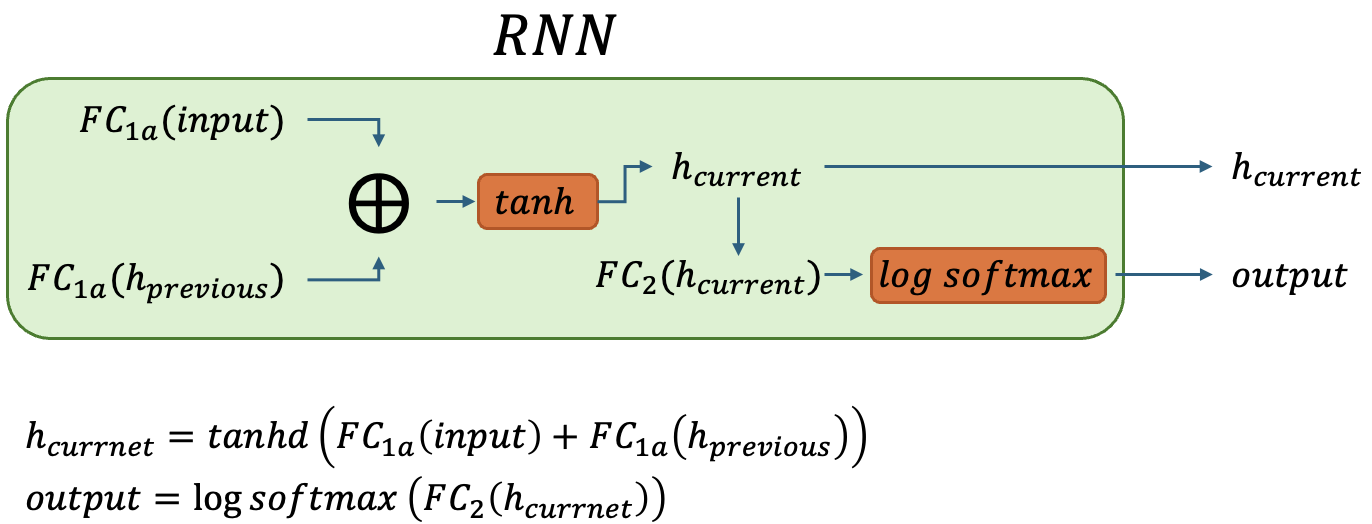

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        #To Do start
        # Hint: 
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size) ### construct FC1a
        self.h2h = nn.Linear(hidden_size, hidden_size) ### construct FC1b
        self.h2o = nn.Linear(hidden_size, output_size) ### construct FC2
        #To Do end
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden): ### implement the forward propegation
        #To Do start
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        #To Do end
        return output, hidden

    def initHidden(self): ### Inatialize h0 to zeros when 'initHidden' is called
        # Initialize the network by constructing a zeros tensor that will be inputted to the 'hidden state'.
        #To Do start
        return torch.zeros(1, self.hidden_size) #To DO? Inatialze the hidden input into zeros
        #To Do end

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We\'ll get back the output (probability
of each language) and a next hidden state (which we keep for the next
step).


In [8]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

#To Do start
output, next_hidden = rnn(input, hidden)
# output, next_hidden = None, None #To Do
#To Do end

For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [9]:
input = lineToTensor('Albert')  ### This is a simple test
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
test_out = torch.zeros(1,18)
assert output.size() == test_out.size(), 'failed the simple test!'

tensor([[-2.9282, -2.8874, -2.8031, -2.8733, -2.9701, -2.9938, -2.7337, -3.0695,
         -2.9872, -2.8736, -2.7876, -2.8284, -3.0101, -2.9308, -2.7077, -2.9227,
         -2.9190, -2.8802]], grad_fn=<LogSoftmaxBackward0>)


You should find the output to be a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Task-3: Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use `Tensor.topk` to get the index
of the greatest value:


In [7]:
a=torch.rand(1,18)
print(a, a.topk(1))

tensor([[0.6945, 0.3286, 0.9860, 0.5567, 0.2210, 0.8800, 0.7342, 0.9251, 0.6960,
         0.7974, 0.9737, 0.7848, 0.0510, 0.6083, 0.5630, 0.9603, 0.1764, 0.2514]]) torch.return_types.topk(
values=tensor([[0.9860]]),
indices=tensor([[2]]))


In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 14)


We will also want a quick way to get a training example (a name and its
language):


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    # sample a random surname (i.e. line) with its langauge of origin (i.e. category)
    # Hint: get use of the variables 'all_categories' and 'category_lines'
    #To Do start
    category = randomChoice(all_categories)   ### choose a random category (i.e. language of origin)
    line = randomChoice(category_lines[category]) ### choose a random line (i.e. a surname)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) ### convert them to tensors
    line_tensor = lineToTensor(line)
    #To Do end
    return category, line, category_tensor, line_tensor # e.g. Czech, Wood, tensor([0]), tensor with size (4, 1, 57)

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample() ### run 10 examples
    print('category =', category, '/ line =', line)


category = Japanese / line = Akimoto
category = Japanese / line = Takewaki
category = Spanish / line = Gutierrez
category = French / line = Dubois
category = Spanish / line = Michel
category = Irish / line = O'Connor
category = Vietnamese / line = Giang
category = Polish / line = Bernard
category = Japanese / line = Tsubouchi
category = Chinese / line = Yan


Task-4: Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer
of the RNN is `nn.LogSoftmax`.


In [12]:
criterion = nn.NLLLoss()

The goal is leanr the RNN model\'s parameters using gradient decend. Therefore, the loss function will be calculated then its gradient will be found $\left(i.e.\ \frac{\partial J(\theta)}{\partial \theta}\right)$. It will be then multiplied by the negative of the learning rate to update the RNN model\'s parameters $\left(i.e.\ \theta_{upd}=\theta_{old}-\alpha\frac{\partial J(\theta)}{\partial \theta}\right)$. 

In each training loop we will:
-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


What is the effect of the learning rate?

![WhatsApp Image 2024-08-01 at 2.58.09 AM.jpeg](<attachment:WhatsApp Image 2024-08-01 at 2.58.09 AM.jpeg>)
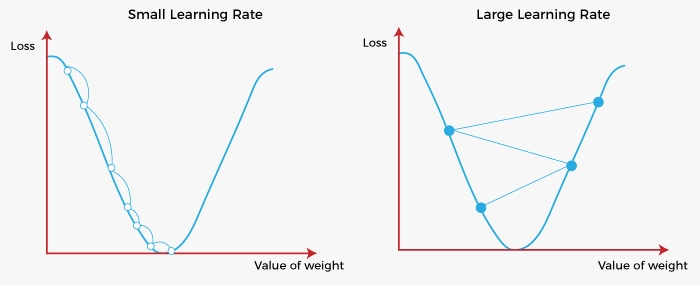

In [13]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    #To Do start
    hidden = rnn.initHidden()
    # hidden = None # initialize the hidden state; hint: you already built the needed method
    #To Do start

    rnn.zero_grad()

    #To Do start
    for i in range(line_tensor.size()[0]): ### go through letter by letter
        output, hidden = rnn(line_tensor[i], hidden)
        # output, hidden = None, None

    loss = criterion(output, category_tensor) ### compute the loos using the correct label and the predicted output
    # loss = None
    #To Do end
    loss.backward()   ### performe back propogation

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters(): ### update the RNN model's parameters th_n=th_o-a*grad
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [14]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

#To Do start
for iter in range(1, n_iters + 1):
# for iter in None:
    # Find current_loss
    category, line, category_tensor, line_tensor = randomTrainingExample() ### pick a random sample
    output, loss = train(category_tensor, line_tensor)  ### train on it and find the loss
    current_loss += loss   ### update the loss until we reach 'plot_every'
    # current_loss = None
#To Do end

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:   ### if we reached the print limit, print the output
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:   ### if we reached the plot limit, plot the current_loss and reset it to zero
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.6517 Kwang  / Arabic ✗ (Korean)
10000 10% (0m 4s) 1.2371 Gerver / German ✓
15000 15% (0m 6s) 1.9907 Mckay / Czech ✗ (Scottish)
20000 20% (0m 8s) 1.9228 See  / Korean ✗ (Chinese)
25000 25% (0m 11s) 1.5310 White / Scottish ✓
30000 30% (0m 13s) 0.3758 Rosario / Portuguese ✓
35000 35% (0m 15s) 2.0584 Mochulsky / Scottish ✗ (Russian)
40000 40% (0m 17s) 2.2187 Sims / Dutch ✗ (English)
45000 45% (0m 20s) 0.1169 Nakano / Japanese ✓
50000 50% (0m 22s) 0.4082 Rzehak / Czech ✓
55000 55% (0m 24s) 0.0391 Jaskulski / Polish ✓
60000 60% (0m 26s) 2.4818 Albert / French ✗ (German)
65000 65% (0m 28s) 0.1560 Srpcikova / Czech ✓
70000 70% (0m 31s) 0.6099 Curran / Irish ✓
75000 75% (0m 33s) 0.3724 Hodoval / Czech ✓
80000 80% (0m 35s) 0.0402 Nguyen / Vietnamese ✓
85000 85% (0m 37s) 1.4524 Hua / Vietnamese ✗ (Chinese)
90000 90% (0m 39s) 0.2490 Morcos / Arabic ✓
95000 95% (0m 41s) 0.3627 Yue / Chinese ✓
100000 100% (0m 44s) 0.1710 Delgado / Portuguese ✓


Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


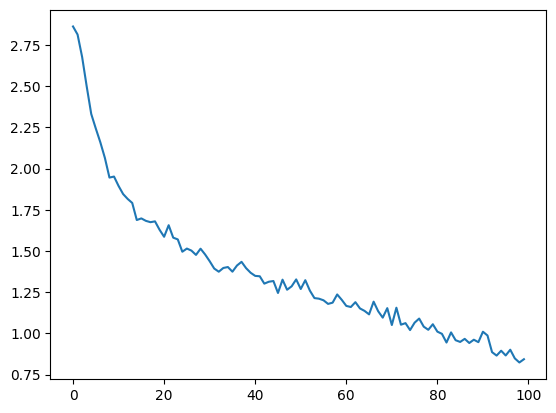

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Task-5: Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


/var/folders/7f/r2ps86p562s640d2zx6tvwm40000gq/T/ipykernel_47398/369868820.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/7f/r2ps86p562s640d2zx6tvwm40000gq/T/ipykernel_47398/369868820.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


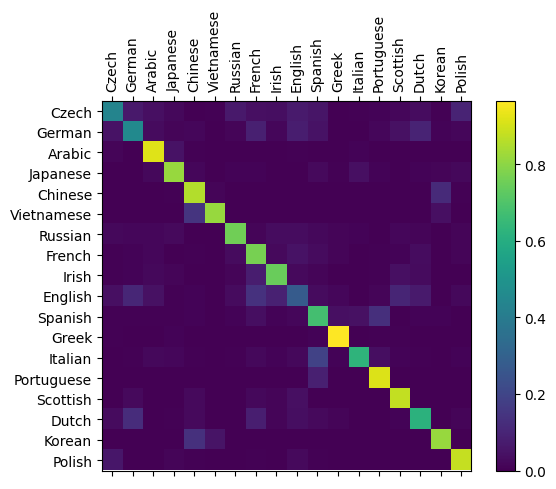

In [16]:
# Keep track of correct guesses in a confusion matrix
# To Do start
confusion = torch.zeros(n_categories, n_categories)
# confusion = None # build a nxn tensor matrix with the correct dimension
# To Do end
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    # To Do start
    # initialize the hidden state then evaluate the line character after the other sequentially
    hidden = rnn.initHidden() ### inatiate h0 to zeros before evaluating

    for i in range(line_tensor.size()[0]):   ### start forward propogation
        output, hidden = rnn(line_tensor[i], hidden)
    # To Do end

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):   ### run 'n_confusion' predictions
    # To Do start
    # construct the 'confusion' matrix.
    # Hint1: the diagonal of the matrix corresponds to the correctly classified categories and any other element represent a false classification.
    #        Each prediction will increment the corresponding element by 1.
    # Hint2: a row would represnt the category index and a column would represent the predicted category index
    category, line, category_tensor, line_tensor = randomTrainingExample()    ### pick a random sample
    output = evaluate(line_tensor)   ### predict the output probality distribution
    guess, guess_i = categoryFromOutput(output)   ### convert the prob. dist. to the actual category (i.e. langauge of origin)
    category_i = all_categories.index(category)   ### Find the category index
    confusion[category_i][guess_i] += 1   ### fill the corresponding element in the confusion matrix
    # confusion = None
    # To Do end

# Normalize by dividing every row by its sum
for i in range(n_categories):   ### Normalize the matrix
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

How did our model perform during evaluation? Kindly explain your observation.

ANSWER: You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

print('Predict some examples...')
predict('Dovesky')
predict('Jackson')
predict('Satoshi')

Predict some examples...

> Dovesky
(-0.43) Russian
(-1.31) Czech
(-3.17) Polish

> Jackson
(-0.04) Scottish
(-3.49) English
(-5.72) Russian

> Satoshi
(-0.48) Japanese
(-1.34) Arabic
(-2.42) Italian


Who did win the competition? Is it humans or the AI model!?
=====================


In [18]:
print(all_categories)
predict('Alshams')
predict('Lee')
predict('Inza')
predict('Laquai')

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']

> Alshams
(-0.45) English
(-1.98) Greek
(-2.45) Scottish

> Lee
(-0.17) Chinese
(-2.48) Korean
(-2.83) Vietnamese

> Inza
(-1.10) Japanese
(-1.55) Czech
(-1.70) Spanish

> Laquai
(-1.11) Japanese
(-1.15) Italian
(-1.75) Arabic
